# PyTorch CNN Tutorial

Production-ready CNN using **PyTorch**.

This notebook shows the same architecture as the NumPy version but with much faster training.


In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%matplotlib inline


Using device: cpu


## 1. Load Data


In [7]:
from src.utils import load_mnist
from pytorch.cnn_pytorch import create_data_loaders

# Load data
X_train, y_train, X_test, y_test = load_mnist('../mnist_dataset', subset_size=(5000, 1000))

# Create PyTorch data loaders
train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, batch_size=32)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Loaded MNIST: 5000 training, 1000 test samples
Image shape: (1, 28, 28) (channels, height, width)
Training batches: 157
Test batches: 32


## 2. Create and Train Model


In [8]:
from pytorch.cnn_pytorch import CNNPyTorch, train_pytorch_model

# Create model
model = CNNPyTorch(input_channels=1, num_classes=10).to(device)
print(model)
print(f"\nTotal parameters: {model.count_parameters():,}")


CNNPyTorch(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d_2): Dropout2d(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1)

In [10]:
# Train
history = train_pytorch_model(
    model, train_loader, 
    val_loader=test_loader,
    epochs=5,
    learning_rate=0.001,
    device=device,
    verbose=True
)


Epoch 1/5 - Loss: 0.1511 - Acc: 0.9592 - Val Loss: 0.0866 - Val Acc: 0.9770
Epoch 2/5 - Loss: 0.1088 - Acc: 0.9684 - Val Loss: 0.0765 - Val Acc: 0.9780
Epoch 3/5 - Loss: 0.1008 - Acc: 0.9680 - Val Loss: 0.0701 - Val Acc: 0.9790
Epoch 4/5 - Loss: 0.0880 - Acc: 0.9744 - Val Loss: 0.0602 - Val Acc: 0.9780
Epoch 5/5 - Loss: 0.0737 - Acc: 0.9790 - Val Loss: 0.0551 - Val Acc: 0.9820


In [11]:
# Evaluate
from pytorch.cnn_pytorch import evaluate_pytorch_model

test_loss, test_acc = evaluate_pytorch_model(model, test_loader, device)
print(f"\n✓ Test Loss: {test_loss:.4f}")
print(f"✓ Test Accuracy: {test_acc:.2%}")



✓ Test Loss: 0.0551
✓ Test Accuracy: 98.20%


## 3. Feature Map Visualization

Visualize what the convolutional layers "see" using PyTorch hooks.


Feature maps shape: torch.Size([1, 32, 28, 28])


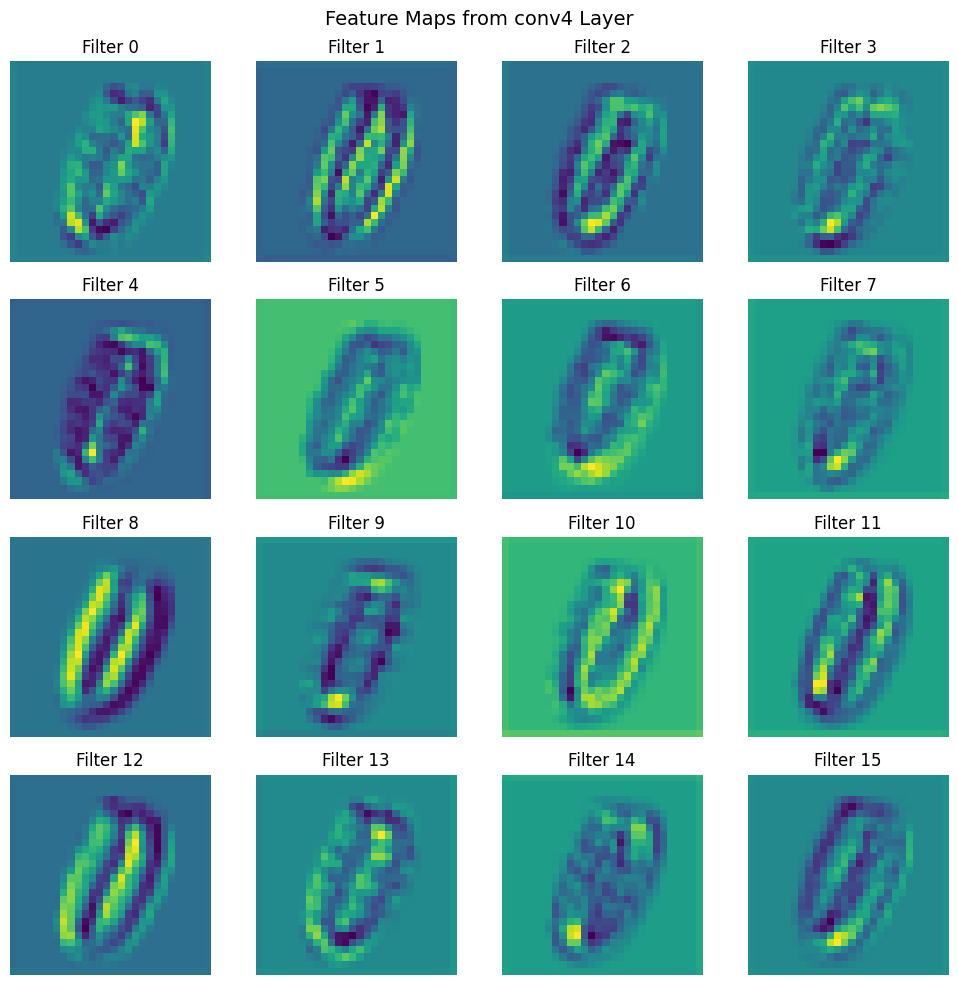

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get a sample image
sample = X_test[:1]  # Shape: (1, 1, 28, 28)
sample_tensor = torch.FloatTensor(sample).to(device)

# Get feature maps from conv4 layer
feature_maps = model.get_feature_maps(sample_tensor, layer_name='conv2')
print(f"Feature maps shape: {feature_maps.shape}")

# Convert to numpy for visualization
fm_np = feature_maps.cpu().numpy()[0]  # Remove batch dim

# Plot first 16 feature maps
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < fm_np.shape[0]:
        ax.imshow(fm_np[i], cmap='viridis')
        ax.set_title(f'Filter {i}')
    ax.axis('off')
plt.suptitle('Feature Maps from conv4 Layer', fontsize=14)
plt.tight_layout()
plt.savefig('../visualizations/pytorch_feature_maps.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Save Model


In [14]:
# Save model
torch.save(model.state_dict(), '../checkpoints/cnn_pytorch.pth')
print("✓ Model saved to ../checkpoints/cnn_pytorch.pth")


✓ Model saved to ../checkpoints/cnn_pytorch.pth
